# Wave with periodic bc with the scheme from Palma

We solve the wave equation with Dirichlet boundary conditions (homogeneous) up to $T = 2L$ where $L$ is the space size of the integrating region. The data is reflection symmetric, $u_0(x) = u_0(L-x)$, $\partial_t u(x,t=0) = 0$. This way at the last point the solution repeats itself and we can measure the error very well.

In [1]:
import Pkg
#Pkg.add("Zygote")
#Pkg.instantiate()
#Pkg.add("StatsBase")
#Pkg.add("UnPack")
#Pkg.add("Revise")
using ComponentArrays
using Distributions
#using WGLMakie
using Lux
using LuxCUDA
using Optim
using OptimizationOptimJL
using Random
using UnPack
using Zygote
#using CairoMakie  # Backend que funciona en notebooks
using StatsBase
using Revise
using Plots
using JLD2
using NBInclude
#import NaNMath

## Status:

Working well in both GPU and CPU without adaptivity. Using both initial data for u and its derivative.

I put some functions here.

In [2]:
includet("../../neural_tools.jl")
includet("config.jl")

In [3]:

config = config_basic
#config = config_test  # switch to config for real run

@show get_parameter_count(config)


get_parameter_count(config) = 1341


1341

**Note 1:** I attempted to put a bump function of compact support (with some if's) and could not make it run. It seems there are problems with the AD scheme to handle if's. So I put a simpler function.

**Note 2:** As it is, with adaptive it takes 12 hours (CPU) to run... And the solution is wrong...

In [4]:
# -------------------------------------------------------------------
# Second order wave equation (onda 1D): u_tt - c^2 u_xx = 0
# -------------------------------------------------------------------

function wave_equation(∂2u_∂x2, ∂2u_∂t2, config) 
    c = config[:c]
    ∂2u_∂t2 .- (c^2) .* ∂2u_∂x2
end

```
Residual at collocation points
``` 

function residual_at_points_Dirichlet(input, NN, Θ, st)
    x, t = input[1:1, :], input[2:2, :]
    _, u_xx, u_tt = calculate_derivatives_Dirichlet(x, t, NN, Θ, st)
    res = wave_equation(u_xx, u_tt, config) 
    abs_res = (abs.(u_xx) .+ abs.(u_tt))
    res = res ./ abs_res
    #res = wave_equation(u_xx, u_tt, config)
    #return vec(abs.(res |> cpu_device()))  # magnitud del residuo en CPU
    #return vec(abs.(res))
    return res
end


# -------------------------------------------------------------------
# Loss function with Dirichlet boundary conditions hard enforced.
# -------------------------------------------------------------------

function loss_function(input, NN, Θ, st)
    res = residual_at_points_Dirichlet(input[1], NN, Θ, st)
    #return log10(sum(abs2, res) / length(res))
    #return log10(sum(abs, res) / length(res))
    return sum(abs, res) / length(res)
end

# -------------------------------------------------------------------
# Callback
# -------------------------------------------------------------------
function callback(p, l, losses)
    println("Current loss: ", l)
    push!(losses, log10(l))
    return false
end

callback (generic function with 1 method)

In [5]:
#loss_function(input_total, NN, Θ, st)

Initial data:

In [5]:
includet("wave_ini_bound_data.jl")

#plot(u0, xmin, xmax, title="Initial displacement u0(x) and velocity u1(x)", xlabel="x", ylabel="u0/u1", label="u0")
#plot!(u1, xmin, xmax, label="u1")

### Results:

1. With the p=4 polynomial data works OK and the error is of low frequency.
2. With the p=2 sin data it does not work. Start decreasing the loss function but at some point there is a problem with the optimizer and it does not improve further, on the contrary the loss stabilizes in a larger value.
It seems to be going with smaller t evolution (as if the speed were smaller)
3. We tried with rescaling the residual by the norm of the derivatives, but it does not work with SSB nor with the log10 transformation. It works very slowly with BB. 

In [6]:
input = generate_input_x_t(config)
input0 = generate_input0_x(config)
input_bound = generate_input_boundary_x(config)
input_total = [input, input0, input_bound]

@show typeof(input_total) size(input_total)
@show get_parameter_count(config)

#input_cpu = input |> cpu_device()

# plot the inputs is needed
#scatter(input_cpu[1,:], input_cpu[2,:], markersize=1, title="Collocation points", xlabel="x", ylabel="t")

┌ Warning: No functional GPU backend found! Defaulting to CPU.
│ 
│ 1. If no GPU is available, nothing needs to be done. Set `MLDATADEVICES_SILENCE_WARN_NO_GPU=1` to silence this warning.
│ 2. If GPU is available, load the corresponding trigger package.
│     a. `CUDA.jl` and `cuDNN.jl` (or just `LuxCUDA.jl`) for  NVIDIA CUDA Support.
│     b. `AMDGPU.jl` for AMD GPU ROCM Support.
│     c. `Metal.jl` for Apple Metal GPU Support. (Experimental)
│     d. `oneAPI.jl` for Intel oneAPI GPU Support. (Experimental)
└ @ MLDataDevices.Internal /Users/reula/.julia/packages/MLDataDevices/NeohJ/src/internal.jl:112


typeof(input_total) = Vector{Array{Float64}}
size(input_total) = (3,)
get_parameter_count(config) = 1341


1341

In [7]:
# -------------------------------------------------------------------
# Entrenamiento
# -------------------------------------------------------------------
losses = []
NN, Θ, st = create_neural_network(config)


#input_total[1] === input

(Chain{@NamedTuple{layer_1::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_4::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_5::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}((layer_1 = Dense(2 => 20, tanh), layer_2 = Dense(20 => 20, tanh), layer_3 = Dense(20 => 20, tanh), layer_4 = Dense(20 => 20, tanh), layer_5 = Dense(20 => 1)), nothing), (layer_1 = (weight = [1.0948718786239624 1.072461724281311; -0.350408136844635 0.7485936284065247; … ; -1.3098055124282837 -1.5650660991668701; -0.5334498286247253 1.2700445652008057], bias = [0.1994149535894394, 0.6821088790893555, -0.6524060964584351, -0.39216309785842896, -0.4157487452030182, -0.6731748580932617, -0.17935052514076233, 0.597272515296936, 0.5622634887695312, 0.04637636989355087, -0.5784315466880798, 0.

In [9]:
#res = residual_at_points_Dirichlet(input_total[1], NN, Θ, st)
#res_cpu = res |> cpu_device()
#@show typeof(res_cpu) size(res_cpu)
#res_cpu

In [8]:
loss_function(input_total, NN, Θ, st)

0.9998817741760663

In [11]:


#calculate_Dirichlet_f(input[1:1, :], input[2:2, :], NN, Θ, st)
#f, ∂2f_∂x2, ∂2f_∂t2 = calculate_derivatives_Dirichlet(input[1:1, :], input[2:2, :], NN, Θ, st)

In [ ]:
Θ, st, losses = compute_solution_1d(config, input_total, NN, Θ, st, losses)

In [10]:
# Parámetros optimizados a CPU si procede
Θ_cpu = Θ |> cpu_device()

ComponentVector{Float64}(layer_1 = (weight = [1.0948718786239624 1.072461724281311; -0.350408136844635 0.7485936284065247; … ; -1.3098055124282837 -1.5650660991668701; -0.5334498286247253 1.2700445652008057], bias = [0.1994149535894394, 0.6821088790893555, -0.6524060964584351, -0.39216309785842896, -0.4157487452030182, -0.6731748580932617, -0.17935052514076233, 0.597272515296936, 0.5622634887695312, 0.04637636989355087, -0.5784315466880798, 0.023259244859218597, 0.510290265083313, 0.2581217288970947, 0.4350453317165375, -0.6213942766189575, 0.38137468695640564, 0.06317231059074402, 0.016009395942091942, 0.6064157485961914]), layer_2 = (weight = [-0.19718487560749054 -0.5341911911964417 … 0.6130702495574951 -0.6024312973022461; 0.12766051292419434 -0.4256872534751892 … 0.5964066982269287 0.3120407164096832; … ; 0.514171838760376 0.3079964220523834 … 0.35946810245513916 -0.09373074024915695; -0.4945398271083832 -0.6095754504203796 … -0.016537858173251152 -0.23398378491401672], bias = [-0

**Save data:**

In [11]:
println("Training completed. Saving data")
#@save "wave_Dir_1.jld2" config Θ_cpu st losses
#@save "wave_dirichlet_1D_adaptive.jld2" Θ_cpu st config losses
#@save "wave_dirichlet_1D_u0_sin_u1_zero_p8_SSB.jld2" Θ_cpu st config losses
@save "wave_dirichlet_1D_u0_sin_u1_zero_p8_BB.jld2" Θ_cpu st config losses
#@save "wave_dirichlet_1D_test.jld2" Θ_cpu st config losses 

if in_nbinclude()
    exit()
end

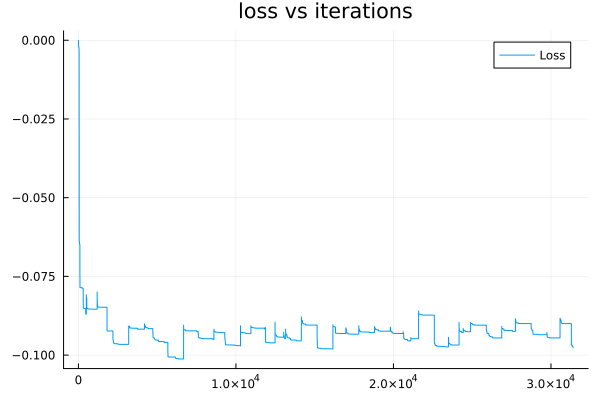

In [12]:
plot(losses, label = "Loss", title = "loss vs iterations") #, yscale = :log10)


In [13]:
losses

config[:tmax]

2.0

In [14]:
NN = create_chain(config)

Chain(
    layer_1 = Dense(2 => 20, tanh),               # 60 parameters
    layer_(2-4) = Dense(20 => 20, tanh),          # 1_260 (420 x 3) parameters
    layer_5 = Dense(20 => 1),                     # 21 parameters
)         # Total: 1_341 parameters,
          #        plus 0 states.

For the initial data with $u_1(x) = \partial_x u_0(x)$ the solution is:

$$ 
u(x,t) = 
\begin{cases}
& u_0(x+t) \;\;\;\; t \leq x \;\;\text{and} \;\;  t \leq 1 - x \\
& u_0(x+t) - u_0(x-t) \;\;\;\;\; t \geq x \;\; \text{and} \;\; t \leq 1 - x \\
& 0 \;\;\;\;\; t \leq x \;\; \text{and} \;\; t \geq 1 - x \\
& - u_0(x-t) \;\;\;\;\; t \geq x \;\; \text{and} \;\; t \geq 1 - x ;\; \text{and} \;\; t \leq 1 + x \\
\end{cases} 
$$

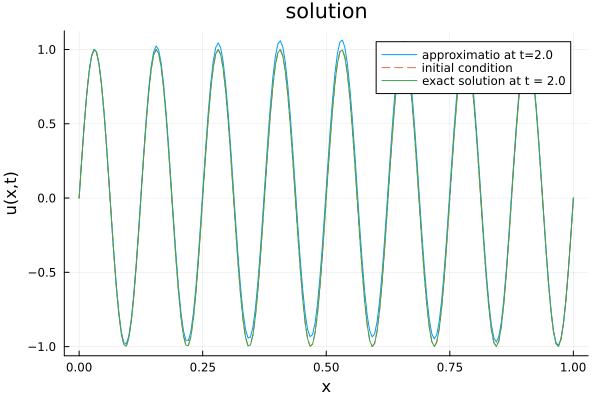

In [18]:
#@unpack xmin, xmax, A, B, p = config
t = 2.
xs = reshape(collect(range(config[:xmin], config[:xmax], length=200)), 1, :)
t_fix = reshape(fill(t, length(xs)), 1, :)
#sol_p = [calculate_Dirichlet_f(xs, t_fix, NN, Θ, st) for x in xs]
sol_p = [calculate_Dirichlet_f_wf(xs[:,i], t_fix[:,i], NN, Θ_cpu, st)[1] for i in 1:length(xs[1,:])]

plot(xs[1,:],sol_p, label = "approximatio at t=$t", title = "solution")
#lines!(xs[1,:],bump.(xs[1,:], config[:x0], config[:x1], config[:p], config[:A]), label = "initial condition")
plot!(xs[1,:],u0(xs[1,:]), label = "initial condition", linestyle = :dash)  
plot!(xlabel = "x", ylabel = "u(x,t)")   
plot!(xs[1,:], A*(sin.(2π*(xs[1,:].+t)*p/(xmax - xmin)) + sin.(2π*(xs[1,:].-t)*p/(xmax - xmin)))/2, label = "exact solution at t = $t")  # exact solution at t=2.0


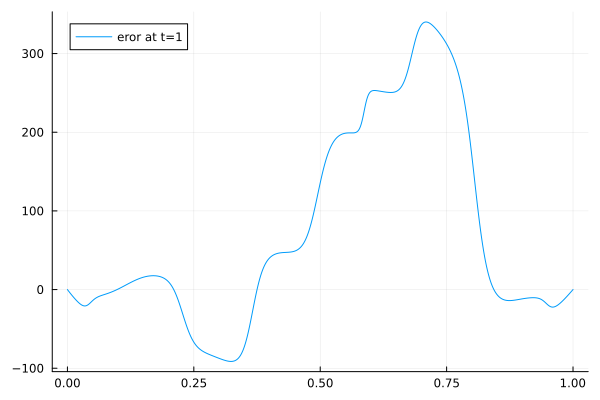

In [19]:
ax = (title = "solution")
t = 1.0
xs = reshape(collect(range(config[:xmin], config[:xmax], length=20000)), 1, :)
t_fix = reshape(fill(t, length(xs)), 1, :)
sol_p = [calculate_Dirichlet_f_wf(xs[:,i], t_fix[:,i], NN, Θ_cpu, st)[1] for i in 1:length(xs[1,:])]

plot(xs[1,:],sol_p .+ u0.(xs[1,:]), label = "eror at t=1")